In [21]:
from google.cloud import vision
from google.cloud.vision import types
import io
from PIL import Image, ImageDraw
from enum import Enum
import re
import string 
from aadhar import isValid
import math


# Utility Functions

In [2]:
def assemble_word(word):
    assembled_word=""
    for symbol in word.symbols:
        assembled_word+=symbol.text
    return assembled_word

In [3]:
def find_block_location(document,word_to_find):
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    assembled_word=assemble_word(word)
                    if(assembled_word==word_to_find):
                        return block.bounding_box

In [4]:
def find_word_location(document,word_to_find):
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    assembled_word=assemble_word(word)
                    if(assembled_word==word_to_find):
                        return word.bounding_box

In [5]:
class FeatureType(Enum):
    PAGE = 1
    BLOCK = 2
    PARA = 3
    WORD = 4
    SYMBOL = 5
    
def draw_boxes(image, bounds, color,width=2):
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        draw.line([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y,
            bound.vertices[0].x, bound.vertices[0].y],fill=color, width=width)
    return image

def get_document_bounds(response, feature):
    bounds=[]
    for i,page in enumerate(document.pages):
        for block in page.blocks:
            if feature==FeatureType.BLOCK:
                bounds.append(block.bounding_box)
            for paragraph in block.paragraphs:
                if feature==FeatureType.PARA:
                    bounds.append(paragraph.bounding_box)
                for word in paragraph.words:
                    for symbol in word.symbols:
                        if (feature == FeatureType.SYMBOL):
                            bounds.append(symbol.bounding_box)
                    if (feature == FeatureType.WORD):
                        bounds.append(word.bounding_box)
    return bounds


In [6]:
def text_within(document,x1,y1,x2,y2): 
    text=""
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        min_x=min(symbol.bounding_box.vertices[0].x,symbol.bounding_box.vertices[1].x,symbol.bounding_box.vertices[2].x,symbol.bounding_box.vertices[3].x)
                        max_x=max(symbol.bounding_box.vertices[0].x,symbol.bounding_box.vertices[1].x,symbol.bounding_box.vertices[2].x,symbol.bounding_box.vertices[3].x)
                        min_y=min(symbol.bounding_box.vertices[0].y,symbol.bounding_box.vertices[1].y,symbol.bounding_box.vertices[2].y,symbol.bounding_box.vertices[3].y)
                        max_y=max(symbol.bounding_box.vertices[0].y,symbol.bounding_box.vertices[1].y,symbol.bounding_box.vertices[2].y,symbol.bounding_box.vertices[3].y)
                        if(min_x >= x1 and max_x <= x2 and min_y >= y1 and max_y <= y2):
                            text+=symbol.text
                            if(symbol.property.detected_break.type==1 or 
                               symbol.property.detected_break.type==3):
                                text+=' '
                            if(symbol.property.detected_break.type==2):
                                text+='\t'
                            if(symbol.property.detected_break.type==5):
                                text+='\n'
    return text

In [7]:
def find_nearest_words(document,word,radius):
    word_bounding_box = find_word_location(document,word)
    text = ""
    if(not word_bounding_box):
        return text
    centroid_x =  ( word_bounding_box.vertices[0].x + word_bounding_box.vertices[2].x )/2
    centroid_y =  ( word_bounding_box.vertices[0].y + word_bounding_box.vertices[2].y )/2
    
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        x_c = (word.bounding_box.vertices[0].x + word.bounding_box.vertices[2].x)/2
                        y_c = (word.bounding_box.vertices[0].y + word.bounding_box.vertices[2].y)/2
                    
                        distance = math.sqrt((x_c-centroid_x)**2 + (y_c-centroid_y)**2)
                        if(distance<=radius):
                            text+=symbol.text
                            if(symbol.property.detected_break.type==1 or 
                               symbol.property.detected_break.type==3):
                                text+=' '
                            if(symbol.property.detected_break.type==2):
                                text+='\t'
                            if(symbol.property.detected_break.type==5):
                                text+='\n'
    
    return text

In [8]:
def find_required_words(document,input_word,category = 1.0):
    bounding_box_input_word = find_word_location(document,input_word)
    if(bounding_box_input_word):
        width_input_word = bounding_box_input_word.vertices[2].y - bounding_box_input_word.vertices[0].y
        length_input_word = bounding_box_input_word.vertices[2].x - bounding_box_input_word.vertices[0].x

        min_x = bounding_box_input_word.vertices[0].x - length_input_word/2.0
        max_x = bounding_box_input_word.vertices[2].x + category * length_input_word
        min_y = bounding_box_input_word.vertices[0].y - width_input_word/2.0
        max_y = bounding_box_input_word.vertices[2].y + 2.0 * width_input_word

        text = text_within(document,min_x,min_y,max_x,max_y)
        return text

In [9]:
def find_all_word_location(document,word_to_find):
    list_bounding_box = []
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    assembled_word=assemble_word(word)
                    if(assembled_word==word_to_find):
                        list_bounding_box.append(word.bounding_box)
    return list_bounding_box

In [19]:
date_pattern = re.compile(r'(?:(?:31(\/|-|\.)(?:0?[13578]|1[02]))\1|(?:(?:29|30)(\/|-|\.)(?:0?[13-9]|1[0-2])\2))(?:(?:1[6-9]|[2-9]\d)?\d{2})|(?:29(\/|-|\.)0?2\3(?:(?:(?:1[6-9]|[2-9]\d)?(?:0[48]|[2468][048]|[13579][26])|(?:(?:16|[2468][048]|[3579][26])00))))$|(?:0?[1-9]|1\d|2[0-8])(\/|-|\.)(?:(?:0?[1-9])|(?:1[0-2]))\4(?:(?:1[6-9]|[2-9]\d)?\d{2})')

doi_pattern = re.compile(r'DOI|Issue')
cog_pattern = re.compile(r'LMV|MCWG|MCWOG') #Can expand to more categories

In [10]:
image_file='dl.jpg'
image  = Image.open(image_file)

In [17]:
f = open("document_data.json", "x")

# Calling the API

In [12]:
client = vision.ImageAnnotatorClient()
with io.open(image_file, 'rb') as image_file1:
        content = image_file1.read()
content_image = types.Image(content=content)
response = client.document_text_detection(image=content_image)
document = response.full_text_annotation

In [13]:
print(document.text)

THE UNION OF INDIA
MAHARASHTRA STATE MOTOR DRIVING LICENCE
DL No MH01 20180008051 DOI: 05-03-2018
Valid Till 04-03-2038 (NT)
05-03-2018
AUTHORISATION TO DRIVE FOLLOWING CLASS
OF VEHICLES THROUGHOUT INDIA
COV DOI
LMV 05-03-2018
MCWG 05-03-2018
DOB : 13-03-1997 BG: A+
Name UDESHNA BORAH
S/D/W of. POBITRA KUMAR BORAH
Add TD 3/5 AIR FORCE CAMP COTTON GREEN
Mumbal Urban
Mumbal, MH
PIN 400033 37 w usta
Signature & ID of 3
Issuing Authority MH01
Signature/Thumb
Impression of Holder



In [16]:
for num_line,line in enumerate(document.text.split('\n')):
    if 'Issue' in line or 'DOI' in line:
        print(line)
        print(num_line)

Issue Date: 12-07-2018
6


In [20]:
f.write(str(document))
f.close()

# DOI

In [16]:
#TODO Valid From
doi_location = find_all_word_location(document,'DOI')
if not (doi_location):
    doi_location = find_all_word_location(document,'Issue')
doi_dates = []
for doi in doi_location:
    #Extracting the Date in same line in locality
    min_x = doi.vertices[2].x + 10 
    max_x = doi.vertices[2].x + 10 * (doi.vertices[2].x-doi.vertices[0].x)
    min_y = doi.vertices[0].y - (doi.vertices[2].y - doi.vertices[0].y)/2.0
    max_y = doi.vertices[2].y + (doi.vertices[2].y - doi.vertices[0].y)/2.0
    init_text = text_within(document,min_x,min_y,max_x,max_y)
    #If we dont find the text, we look below
    if not init_text:
        min_x = doi.vertices[0].x - (doi.vertices[2].x-doi.vertices[0].x)
        max_x = doi.vertices[2].x + 2 * (doi.vertices[2].x-doi.vertices[0].x)
        min_y = doi.vertices[2].y + 1
        max_y = doi.vertices[2].y + (doi.vertices[2].y - doi.vertices[0].y) * 2 
        init_text = text_within(document,min_x,min_y,max_x,max_y)
    date_matcher = date_pattern.search(init_text)
    if(date_matcher):
        doi_dates.append(date_matcher.group(0))

# Valid Till 

# DL No

In [56]:
car_brands = ['HYUNDAI','TATA','MARUTI-SUZUKI','FORD','BMW','JEEP','MAHINDRA','HONDA','RENAULT','VOLKSWAGEN','AUDI','FIAT','NISSAN','TOYOTA','DATSUN','VOLVO','SKODA','MITSUBISHI']
policy_doc_attributes = ['Make','Model','body','Policy no','Chassis','Engine','Policy Number','Start','End']
dl_attributes = ['Name','DL No|Licence No','DOI|Valid','upto|Valid']

dl_issue = ""
split_document = document.text.split('\n')

#['Make','Model','body','Policy no','Chassis','Engine','Policy Number','Start','End']
for line in split_document:
    p = re.compile('DOI|Issued')
    m = p.search(line)
    if(m):
        if(line[m.span()[1]:m.span()[1]+10]):
            dl_issue = line[m.span()[1]:m.span()[1]+10]




#print(document.text)
    

In [24]:
dates = []
lines = document.text.split('\n')
for line in lines:
    #print(line)
    words = line.split(' ')
    #print(words)
    for word in words:
        #print(word)
        m = date_pattern.search(word)
        doi = doi_pattern.search(word)
        cog = cog_pattern.search(word)
        if(doi):
            #print(doi.group(0))
            date_mat = date_pattern.search(line)
            if(date_mat):
                print(date_mat.group(0))
        if(cog):
            cog_location = find_word_location(document,cog.group(0))
            print(find_required_words(document,cog.group(0),5.0))
        if(m):
            dates.append(m.group(0))
            

12-07-2018


In [25]:
dates

['26-06-2018', '12-07-2018', '16-05-1968', '10-07-2018', '09-01-2018']

In [97]:
for date in dates:
    print(find_nearest_words(document,date[-4:],100))

DRIVING LICENCE DOI: 05-03-2018 05-03-2018 FOLLOWING CLASS INDIA

THE UNION MAHARASHTRA STATE MOTOR No MH01 20180008051 Till 04-03-2038 (NT)
AUTHORISATION TO OF VEHICLES THROUGHOUT COV DOI LMV 05-03-MCWG 05-
DRIVING LICENCE DOI: 05-03-2018 05-03-2018 FOLLOWING CLASS INDIA

DRIVING LICENCE DOI: 05-03-2018 05-03-2018 FOLLOWING CLASS INDIA

DRIVING LICENCE DOI: 05-03-2018 05-03-2018 FOLLOWING CLASS INDIA

DOI 05-03-2018 05-03-2018
: 13-03-1997 BG: A+ BORAH COTTON GREEN 


In [96]:
print(document.text)

THE UNION OF INDIA
MAHARASHTRA STATE MOTOR DRIVING LICENCE
DL No MH01 20180008051 DOI: 05-03-2018
Valid Till 04-03-2038 (NT)
05-03-2018
AUTHORISATION TO DRIVE FOLLOWING CLASS
OF VEHICLES THROUGHOUT INDIA
COV DOI
LMV 05-03-2018
MCWG 05-03-2018
DOB : 13-03-1997 BG: A+
Name UDESHNA BORAH
S/D/W of. POBITRA KUMAR BORAH
Add TD 3/5 AIR FORCE CAMP COTTON GREEN
Mumbal Urban
Mumbal, MH
PIN 400033 37 w usta
Signature & ID of 3
Issuing Authority MH01
Signature/Thumb
Impression of Holder



In [ ]:
make_location = find_word_location(document,m[0])
model_location = find_word_location(document,m[0])
typeofbody_location = find_word_location(document,m[0])

# Plotting bounding boxes 

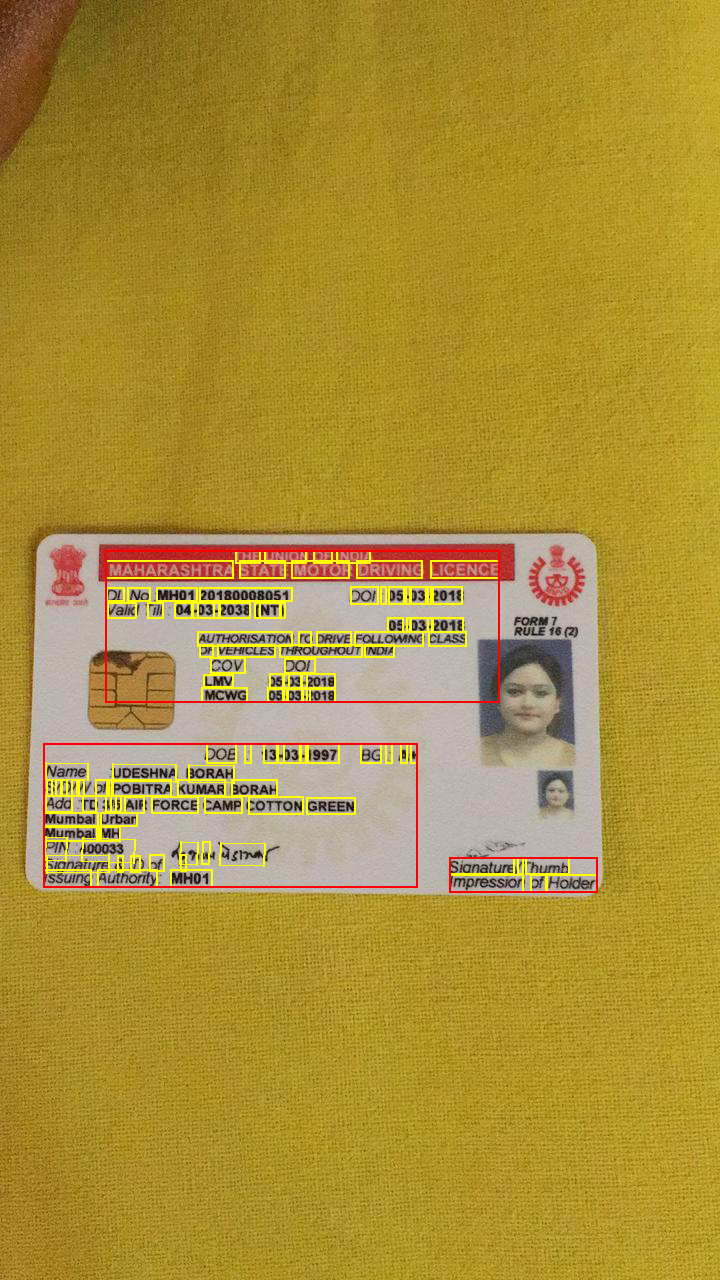

In [18]:
#FOR WORDS
bounds = get_document_bounds(response, FeatureType.WORD)
draw_boxes(image, bounds, 'yellow')
#FOR BLOCKS
bounds = get_document_bounds(response, FeatureType.BLOCK)
draw_boxes(image, bounds, 'red')

# Finding location of a word

In [12]:
# vision_client = vision.ImageAnnotatorClient()

# with io.open(image_file, 'rb') as image_file2:
#     content = image_file2.read()

# content_image = types.Image(content=content)
# response = client.document_text_detection(image=content_image)
# document = response.full_text_annotation

In [46]:
dl_pattern = re.compile('DL|License')
policy_pattern = re.compile('Policy No|Policy number')

In [47]:
stripped_document = document.text.split('\n')
dl_pattern = re.compile('DL|License')
for x in stripped_document:
    dl_matcher = dl_pattern.search(x)
    policy_matcher = policy_pattern.search(x)
    if(dl_matcher):
        x = x.replace(" ","")
        dl_matcher = dl_num_pattern.search(x)
        if(dl_matcher):
            print(dl_matcher.group(0))
    if(policy_matcher):
        print(x)


Certificate cum Policy No: 3001/W-73046625/00/000


In [30]:
adhaar_num_pattern = re.compile("[0-9]{12}");
pan_num_pattern = re.compile("[A-Z]{5}[0-9]{4}[A-Z]");
dl_num_pattern = re.compile("([A-Z]{2}(-){0,1}[0-9]{2}(19[0-9][0-9]|20[0,1][0-9])[0-9]{7})|([A-Z]{2}(-){0,1}[0-9]{3}(19[0-9][0-9]|20[0,1][0-9])[0-9]{7})");


In [22]:
find_nearest_words(document,'Name',400)
find_nearest_words(document,'DL',400)

'MAHARASHTRA DL NO MH12 lyalip Till : 31-08-सत्यमेव जयते\nOF '

In [20]:
import pandas as pd
field_mapping = pd.read_excel('Challenge 2 - Motor Claims Closed File Review/mapping.xlsx',encoding='utf-8')
print(field_mapping)
field_mapping.to_csv('map.csv',index=False,encoding='utf-8')

   Unnamed: 0    Unnamed: 1    Unnamed: 2           Unnamed: 3  \
0         NaN  Claim Number  Claim Amount              Reg No,   
1         NaN           NaN           NaN  Registration Number   
2         NaN           NaN           NaN             REGN. NO   
3         NaN           NaN           NaN     Regitration No.    
4         NaN           NaN           NaN     Regitration no.    

       Unnamed: 4     Unnamed: 5 Unnamed: 6    Unnamed: 7      Unnamed: 8  \
0  Chassis Number  Engine Number    Mfg. CD         Class    Insured Name   
1          Ch. No        Eng. No       Make         Model  Insured's Name   
2             VIN            NaN        NaN  Type of body             NaN   
3             NaN            NaN        NaN           NaN             NaN   
4             NaN            NaN        NaN           NaN             NaN   

  Unnamed: 9  ...    Unnamed: 13        Unnamed: 14      Unnamed: 15  \
0     Driver  ...     Policy No.  Policy Start date  Policy End date

In [ ]:
'''
Insurance Policy Number 
Claim Date
Engine Number
Chassis Number
Vehicle registration number
Vehicle make, model and type of body
Driving license number of the driver 
Insurance Policy start date should be before claim intimation date and loss date i.e. Policy start date > Claim date
'''